In [8]:
# import necessary libraries
import warnings
warnings.filterwarnings("ignore")
import nltk
from nltk.stem import WordNetLemmatizer
import json
import pickle
import nltk
nltk.download('punkt')
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import SGD
import random
from keras.models import load_model

# create an object of WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# importing the GL Bot corpus file for pre-processing

words=[]
classes = []
documents = []
ignore_words = ['?', '!']
data_file = open("peristiwa_sejarah.json").read()
intents = json.loads(data_file)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kyrif\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 2. Data pre-processing

In [9]:
# preprocessing the json data
# tokenization
#nltk.download('punkt')
nltk.download('wordnet')
for intent in intents['intents']:
    for pattern in intent['patterns']:

        #tokenize each word
        w = nltk.word_tokenize(pattern)
        words.extend(w)
        #add documents in the corpus
        documents.append((w, intent['tag']))

        # add to our classes list
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kyrif\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))

# sort classes
classes = sorted(list(set(classes)))

# documents = combination between patterns and intents
print (len(documents), "documents")

# classes = intents
print (len(classes), "classes", classes)

# words = all words, vocabulary
print (len(words), "unique lemmatized words", words)

# creating a pickle file to store the Python objects which we will use while predicting
pickle.dump(words,open('texts.pkl','wb')) 
pickle.dump(classes,open('labels.pkl','wb'))

72 documents
33 classes ['Ambarawa', 'Ambarawa1', 'Ambarawa2', 'Bandung_lautan_api', 'Bandung_lautan_api1', 'Bandung_lautan_api2', 'Organisasi_Budi_Utomo', 'Organisasi_Budi_Utomo1', 'Organisasi_Budi_Utomo2', 'Peristiwa_Rengasdengklok', 'Peristiwa_Rengasdengklok1', 'Peristiwa_Rengasdengklok2', 'Surat_Kabar_Sin_Po ', 'Surat_Kabar_Sin_Po1', 'g30spki', 'g30spki2', 'g30spki3', 'g30spki4', 'goodbye', 'greeting', 'proklamasi', 'sejarah', 'tokoh_g30spki1', 'tokoh_g30spki2', 'tokoh_g30spki3', 'tokoh_g30spki4', 'tokoh_g30spki5', 'tokoh_g30spki6', 'tokoh_g30spki7', 'tokoh_pencipta_lagu', 'tokoh_pengibar_bendera', 'tokoh_penjahit_bendera', 'tokoh_penulis_naskah']
110 unique lemmatized words ['3', '30', 'adalah', 'ahmad', 'ambarawa', 'apa', 'api', 'bagaimana', 'bandung', 'banyak', 'belakang', 'bendera', 'berapa', 'berdiri', 'berdirinya', 'budi', 'dalam', 'dari', 'dimaksud', 'dimana', 'donal', 'fungsi', 'g30s', 'gerakan', 'golongan', 'hai', 'halo', 'haryono', 'indonesia', 'isaac', 'itu', 'jendral', 

# 3. Creating Training Data

- Pada dasarnya, bag of words adalah representasi sederhana dari setiap teks dalam sebuah kalimat sebagai bag of words-nya.

In [11]:
# create our training data
training = []

# create an empty array for our output
output_empty = [0] * len(classes)

# training set, bag of words for each sentence
for doc in documents:
    # initialize our bag of words
    bag = []
    # list of tokenized words for the pattern
    pattern_words = doc[0]
   
    # lemmatize each word - create base word, in attempt to represent related words
    pattern_words = [lemmatizer.lemmatize(word.lower()) for word in pattern_words]
    
    # create our bag of words array with 1, if word match found in current pattern
    for w in words:
        bag.append(1) if w in pattern_words else bag.append(0)
    # output is a '0' for each tag and '1' for current tag (for each pattern)
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1
    training.append([bag, output_row])

# shuffle features and converting it into numpy arrays
random.shuffle(training)
training = np.array(training)

# create train and test lists
train_x = list(training[:,0])
train_y = list(training[:,1])

print("Training data created")

Training data created


# 5. Creating Modeling 

- Pada proses ini kami akan membuat model jaringan saraf dan menyimpan model tersebut 

In [12]:
from tensorflow.keras.optimizers import SGD
# Create NN model to predict the responses
model = Sequential()
model.add(Dense(256, input_shape=(len(train_x[0]),), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(train_y[0]), activation='softmax'))

from tensorflow.keras.optimizers import SGD

# Compile model. Stochastic gradient descent with Nesterov accelerated gradient gives good results for this model
sgd = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

#fitting and saving the model 
hist = model.fit(np.array(train_x), np.array(train_y), epochs=200, batch_size=5, verbose=1)
model.save('models.h5', hist) # we will pickle this model to use in the future
print("\n")
print("*"*50)
print("\nModel Created Successfully!")

Epoch 1/200
15/15 [==============================] - 1s 3ms/step - loss: 3.5206 - accuracy: 0.0139 
Epoch 2/200
15/15 [==============================] - 0s 6ms/step - loss: 3.4854 - accuracy: 0.0417
Epoch 3/200
15/15 [==============================] - 0s 3ms/step - loss: 3.3833 - accuracy: 0.1250
Epoch 4/200
15/15 [==============================] - 0s 3ms/step - loss: 3.4267 - accuracy: 0.0694
Epoch 5/200
15/15 [==============================] - 0s 5ms/step - loss: 3.2748 - accuracy: 0.1389
Epoch 6/200
15/15 [==============================] - 0s 5ms/step - loss: 3.2579 - accuracy: 0.1111
Epoch 7/200
15/15 [==============================] - 0s 4ms/step - loss: 3.0590 - accuracy: 0.1389
Epoch 8/200
15/15 [==============================] - 0s 3ms/step - loss: 2.9439 - accuracy: 0.1528
Epoch 9/200
15/15 [==============================] - 0s 3ms/step - loss: 2.9167 - accuracy: 0.2083
Epoch 10/200
15/15 [==============================] - 0s 4ms/step - loss: 2.7376 - accuracy: 0.2778
Epoch 11

15/15 [==============================] - 0s 3ms/step - loss: 0.6465 - accuracy: 0.7917
Epoch 84/200
15/15 [==============================] - 0s 3ms/step - loss: 1.0117 - accuracy: 0.7083
Epoch 85/200
15/15 [==============================] - 0s 3ms/step - loss: 0.5734 - accuracy: 0.8333
Epoch 86/200
15/15 [==============================] - 0s 3ms/step - loss: 0.9431 - accuracy: 0.7361
Epoch 87/200
15/15 [==============================] - 0s 3ms/step - loss: 0.7185 - accuracy: 0.8333
Epoch 88/200
15/15 [==============================] - 0s 2ms/step - loss: 1.0870 - accuracy: 0.6944
Epoch 89/200
15/15 [==============================] - 0s 3ms/step - loss: 0.9778 - accuracy: 0.7083
Epoch 90/200
15/15 [==============================] - 0s 3ms/step - loss: 0.7541 - accuracy: 0.7500
Epoch 91/200
15/15 [==============================] - 0s 3ms/step - loss: 0.5844 - accuracy: 0.7917
Epoch 92/200
15/15 [==============================] - 0s 3ms/step - loss: 0.7379 - accuracy: 0.7917
Epoch 93/200


15/15 [==============================] - 0s 3ms/step - loss: 0.9300 - accuracy: 0.7778
Epoch 165/200
15/15 [==============================] - 0s 4ms/step - loss: 0.6699 - accuracy: 0.7917
Epoch 166/200
15/15 [==============================] - 0s 4ms/step - loss: 0.6879 - accuracy: 0.8194
Epoch 167/200
15/15 [==============================] - 0s 3ms/step - loss: 0.7881 - accuracy: 0.7778
Epoch 168/200
15/15 [==============================] - 0s 3ms/step - loss: 0.7084 - accuracy: 0.8333
Epoch 169/200
15/15 [==============================] - 0s 3ms/step - loss: 0.6192 - accuracy: 0.7639
Epoch 170/200
15/15 [==============================] - 0s 3ms/step - loss: 0.8503 - accuracy: 0.7917
Epoch 171/200
15/15 [==============================] - 0s 3ms/step - loss: 0.7873 - accuracy: 0.7639
Epoch 172/200
15/15 [==============================] - 0s 3ms/step - loss: 0.8391 - accuracy: 0.7222
Epoch 173/200
15/15 [==============================] - 0s 3ms/step - loss: 0.8489 - accuracy: 0.7917
Epoc

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               28416     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 33)               

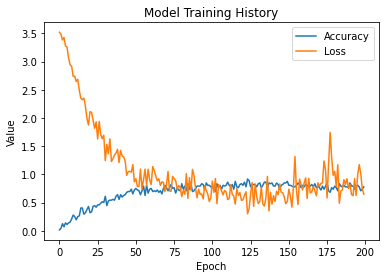

In [14]:
import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'], label='Accuracy')
plt.plot(hist.history['loss'], label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Model Training History')
plt.legend()
plt.show()